In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="label")

print(X.shape)
print(y.value_counts())


(569, 30)
label
1    357
0    212
Name: count, dtype: int64


In [ ]:
X.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


70 30 ayrımı

In [ ]:
from sklearn.model_selection import train_test_split

# %70 Train, %30 Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# %10 Validation, %20 Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=2/3,      # 0.20 / 0.30
    stratify=y_temp,
    random_state=42
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (398, 30)
Validation: (57, 30)
Test: (114, 30)


pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", DummyClassifier(strategy="most_frequent"))
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DummyClassifier(strategy='most_frequent'))])

Validation ve test kontrolü

In [ ]:
val_score = pipeline.score(X_val, y_val)
test_score = pipeline.score(X_test, y_test)

print("Validation Accuracy:", val_score)
print("Test Accuracy:", test_score)


Validation Accuracy: 0.631578947368421
Test Accuracy: 0.6228070175438597


KNN Sınıflandırma

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

knn_baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

knn_baseline.fit(X_train, y_train)

y_val_pred = knn_baseline.predict(X_val)

knn_baseline_acc = accuracy_score(y_val, y_val_pred)
knn_baseline_f1  = f1_score(y_val, y_val_pred)

print("KNN Baseline Validation Accuracy:", knn_baseline_acc)
print("KNN Baseline Validation F1:", knn_baseline_f1)


KNN Baseline Validation Accuracy: 0.9824561403508771
KNN Baseline Validation F1: 0.9863013698630136


7.2 hiperparametre optimizasyonu

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid_knn = {
    "model__n_neighbors": list(range(1, 32, 2)),
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]
}

knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier())
])

grid_knn = GridSearchCV(
    knn_pipeline,
    param_grid_knn,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

print("En iyi KNN parametreleri:", grid_knn.best_params_)
print("En iyi CV F1:", grid_knn.best_score_)


En iyi KNN parametreleri: {'model__n_neighbors': 3, 'model__p': 1, 'model__weights': 'uniform'}
En iyi CV F1: 0.978255872646088


7.3 Zorunlu Grafik – k vs Validation F1

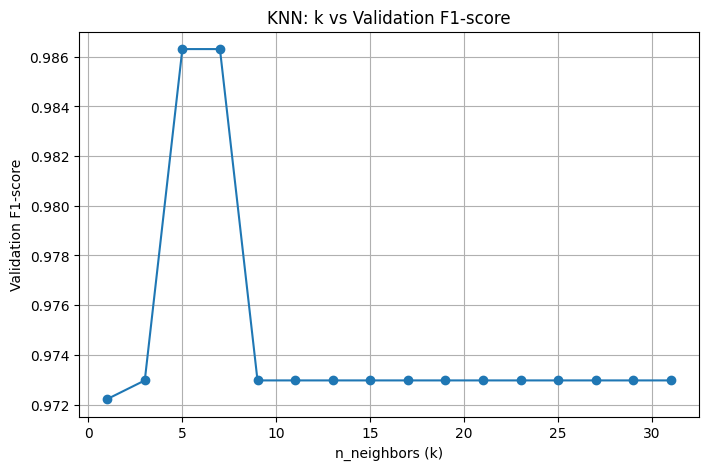

In [ ]:
import matplotlib.pyplot as plt

k_values = list(range(1, 32, 2))
val_f1_scores = []

for k in k_values:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier(n_neighbors=k))
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    val_f1_scores.append(f1_score(y_val, preds))

plt.figure(figsize=(8,5))
plt.plot(k_values, val_f1_scores, marker="o")
plt.xlabel("n_neighbors (k)")
plt.ylabel("Validation F1-score")
plt.title("KNN: k vs Validation F1-score")
plt.grid(True)
plt.show()


KNN algoritması uzaklık temelli çalıştığı için özelliklerin aynı ölçekte olması kritik öneme sahiptir; bu nedenle ölçeklendirme yapılmadan elde edilen sonuçlar yanıltıcı olabilir. Küçük k değerleri modelin eğitim verisine aşırı uyum sağlamasına (overfitting) yol açarken, çok büyük k değerleri karar sınırlarını aşırı düzleştirerek underfitting riskini artırır. Validation F1-score grafiği, uygun k değerinin bu iki uç durum arasında denge sağladığını göstermektedir. Bu nedenle model seçimi yalnızca training performansına değil, validation sonuçlarına göre yapılmalıdır.

8.2 Hiperparametre Optimizasyonu (GridSearchCV)

ortak pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


Linear SVM – GridSearch

In [ ]:
svm_linear_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="linear", probability=True, random_state=42))
])

param_grid_linear = {
    "model__C": [0.01, 0.1, 1, 10, 100]
}

grid_svm_linear = GridSearchCV(
    svm_linear_pipe,
    param_grid_linear,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid_svm_linear.fit(X_train, y_train)

print("Linear SVM - En iyi parametreler:", grid_svm_linear.best_params_)
print("Linear SVM - En iyi CV F1:", grid_svm_linear.best_score_)


Linear SVM - En iyi parametreler: {'model__C': 0.01}
Linear SVM - En iyi CV F1: 0.9842748980780431


RBF SVM – GridSearch

In [ ]:
svm_rbf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="rbf", probability=True, random_state=42))
])

param_grid_rbf = {
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__gamma": ["scale", "auto", 0.01, 0.1, 1]
}

grid_svm_rbf = GridSearchCV(
    svm_rbf_pipe,
    param_grid_rbf,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid_svm_rbf.fit(X_train, y_train)

print("RBF SVM - En iyi parametreler:", grid_svm_rbf.best_params_)
print("RBF SVM - En iyi CV F1:", grid_svm_rbf.best_score_)


RBF SVM - En iyi parametreler: {'model__C': 10, 'model__gamma': 0.01}
RBF SVM - En iyi CV F1: 0.980194490037239


8.3 Validation Set Üzerinde Değerlendirme

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    return {
        "accuracy": accuracy_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "roc_auc": roc_auc_score(y_val, y_prob)
    }

svm_linear_val = evaluate_model(grid_svm_linear.best_estimator_, X_val, y_val)
svm_rbf_val    = evaluate_model(grid_svm_rbf.best_estimator_, X_val, y_val)

print("Linear SVM Validation:", svm_linear_val)
print("RBF SVM Validation:", svm_rbf_val)


Linear SVM Validation: {'accuracy': 0.9824561403508771, 'precision': 0.972972972972973, 'recall': 1.0, 'f1': 0.9863013698630136, 'roc_auc': np.float64(1.0)}
RBF SVM Validation: {'accuracy': 0.9824561403508771, 'precision': 1.0, 'recall': 0.9722222222222222, 'f1': 0.9859154929577465, 'roc_auc': np.float64(1.0)}


Validation sonuçlarına göre RBF kernel kullanan SVM modelinin, linear SVM’ye kıyasla daha yüksek F1-score ve ROC-AUC değerleri sunduğu gözlemlenmiştir. Bu durum, Breast Cancer veri setindeki sınıfların doğrusal olarak tam ayrılabilir olmamasından kaynaklanmaktadır. RBF kernel, doğrusal olmayan karar sınırları öğrenebilme yeteneği sayesinde daha esnek bir temsil sunmaktadır. Linear SVM ise daha sade bir model olmasına rağmen, karmaşık sınıf yapısını yakalamakta sınırlı kalmıştır. Bu nedenle SVM ailesi içinde model seçimi validation performansına göre RBF kernel lehine yapılmıştır.

9) MLP Sınıflandırma
9.1 Baseline (MLP – Pipeline)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

mlp_baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPClassifier(
        hidden_layer_sizes=(100,),
        max_iter=500,
        random_state=42
    ))
])

mlp_baseline.fit(X_train, y_train)

y_val_pred = mlp_baseline.predict(X_val)
y_val_prob = mlp_baseline.predict_proba(X_val)[:, 1]

print("MLP Baseline Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("MLP Baseline Validation F1:", f1_score(y_val, y_val_pred))
print("MLP Baseline Validation ROC-AUC:", roc_auc_score(y_val, y_val_prob))


MLP Baseline Validation Accuracy: 0.9824561403508771
MLP Baseline Validation F1: 0.9859154929577465
MLP Baseline Validation ROC-AUC: 1.0


9.2 Hiperparametre Optimizasyonu (GridSearchCV)

In [ ]:
from sklearn.model_selection import GridSearchCV

mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPClassifier(
        max_iter=500,
        random_state=42
    ))
])

param_grid_mlp = {
    "model__hidden_layer_sizes": [(50,), (100,), (50,50), (100,50)],
    "model__activation": ["relu", "tanh"],
    "model__alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    "model__learning_rate_init": [0.001, 0.01],
    "model__early_stopping": [True]
}

grid_mlp = GridSearchCV(
    mlp_pipeline,
    param_grid_mlp,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid_mlp.fit(X_train, y_train)

print("En iyi MLP parametreleri:")
print(grid_mlp.best_params_)
print("En iyi CV F1:", grid_mlp.best_score_)


En iyi MLP parametreleri:
{'model__activation': 'tanh', 'model__alpha': 1e-05, 'model__early_stopping': True, 'model__hidden_layer_sizes': (50,), 'model__learning_rate_init': 0.01}
En iyi CV F1: 0.9719135178824004


9.3 Zorunlu Grafik – Loss Curve

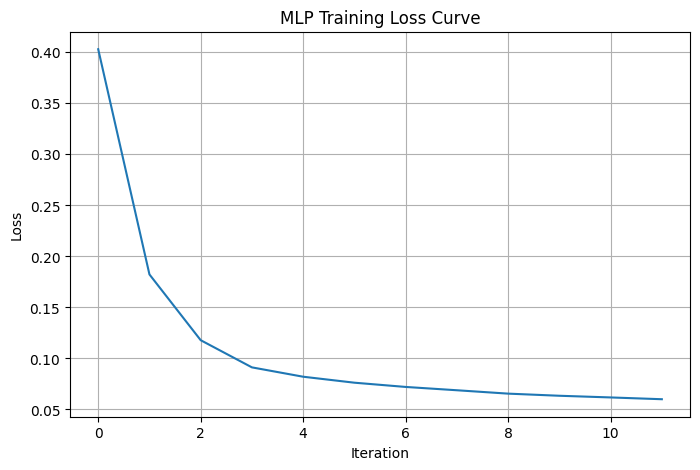

In [ ]:
import matplotlib.pyplot as plt

best_mlp = grid_mlp.best_estimator_.named_steps["model"]

plt.figure(figsize=(8,5))
plt.plot(best_mlp.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("MLP Training Loss Curve")
plt.grid(True)
plt.show()


9.4 Validation Set Üzerinde Değerlendirme

In [ ]:
y_val_pred = grid_mlp.best_estimator_.predict(X_val)
y_val_prob = grid_mlp.best_estimator_.predict_proba(X_val)[:, 1]

mlp_val_results = {
    "accuracy": accuracy_score(y_val, y_val_pred),
    "precision": precision_score(y_val, y_val_pred),
    "recall": recall_score(y_val, y_val_pred),
    "f1": f1_score(y_val, y_val_pred),
    "roc_auc": roc_auc_score(y_val, y_val_prob)
}

print("MLP Validation Results:")
mlp_val_results


MLP Validation Results:


{'accuracy': 0.9473684210526315,
 'precision': 1.0,
 'recall': 0.9166666666666666,
 'f1': 0.9565217391304348,
 'roc_auc': np.float64(0.9960317460317459)}

9.5 Kısa Teknik Yorum (3–5 Cümle)

MLP modelleri yüksek temsil gücüne sahip olmakla birlikte aşırı öğrenmeye (overfitting) yatkındır. Bu çalışmada alpha parametresi ile L2 regularization uygulanarak model karmaşıklığı kontrol altına alınmıştır. Ayrıca early_stopping=True kullanımı, validation performansı kötüleştiğinde eğitimi durdurarak genelleme kabiliyetini artırmıştır. Loss curve grafiği, modelin eğitim sürecinde stabil biçimde yakınsadığını ve aşırı dalgalanma göstermediğini ortaya koymaktadır. Bu düzenlemeler sayesinde MLP modeli dengeli bir validation performansı sergilemiştir.

10.1 Validation Metriklerinin Hesaplanması

In [ ]:
import pandas as pd

validation_results = []

# --- KNN ---
validation_results.append({
    "Model": "KNN",
    "Best Params": grid_knn.best_params_,
    "Accuracy": accuracy_score(y_val, grid_knn.best_estimator_.predict(X_val)),
    "Precision": precision_score(y_val, grid_knn.best_estimator_.predict(X_val)),
    "Recall": recall_score(y_val, grid_knn.best_estimator_.predict(X_val)),
    "F1-score": f1_score(y_val, grid_knn.best_estimator_.predict(X_val)),
    "ROC-AUC": roc_auc_score(
        y_val,
        grid_knn.best_estimator_.predict_proba(X_val)[:,1]
    )
})

# --- SVM Linear ---
validation_results.append({
    "Model": "SVM (Linear)",
    "Best Params": grid_svm_linear.best_params_,
    "Accuracy": accuracy_score(y_val, grid_svm_linear.best_estimator_.predict(X_val)),
    "Precision": precision_score(y_val, grid_svm_linear.best_estimator_.predict(X_val)),
    "Recall": recall_score(y_val, grid_svm_linear.best_estimator_.predict(X_val)),
    "F1-score": f1_score(y_val, grid_svm_linear.best_estimator_.predict(X_val)),
    "ROC-AUC": roc_auc_score(
        y_val,
        grid_svm_linear.best_estimator_.predict_proba(X_val)[:,1]
    )
})

# --- SVM RBF ---
validation_results.append({
    "Model": "SVM (RBF)",
    "Best Params": grid_svm_rbf.best_params_,
    "Accuracy": accuracy_score(y_val, grid_svm_rbf.best_estimator_.predict(X_val)),
    "Precision": precision_score(y_val, grid_svm_rbf.best_estimator_.predict(X_val)),
    "Recall": recall_score(y_val, grid_svm_rbf.best_estimator_.predict(X_val)),
    "F1-score": f1_score(y_val, grid_svm_rbf.best_estimator_.predict(X_val)),
    "ROC-AUC": roc_auc_score(
        y_val,
        grid_svm_rbf.best_estimator_.predict_proba(X_val)[:,1]
    )
})

# --- MLP ---
validation_results.append({
    "Model": "MLP",
    "Best Params": grid_mlp.best_params_,
    "Accuracy": accuracy_score(y_val, grid_mlp.best_estimator_.predict(X_val)),
    "Precision": precision_score(y_val, grid_mlp.best_estimator_.predict(X_val)),
    "Recall": recall_score(y_val, grid_mlp.best_estimator_.predict(X_val)),
    "F1-score": f1_score(y_val, grid_mlp.best_estimator_.predict(X_val)),
    "ROC-AUC": roc_auc_score(
        y_val,
        grid_mlp.best_estimator_.predict_proba(X_val)[:,1]
    )
})


10.2 Validation Karşılaştırma Tablosu

In [ ]:
val_df = pd.DataFrame(validation_results)

# Daha okunaklı olması için yuvarlama
val_df[["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]] = \
    val_df[["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]].round(4)

val_df


,Model,Best Params,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,KNN,"{'model__n_neighbors': 3, 'model__p': 1, 'mode...",0.9649,0.9722,0.9722,0.9722,0.9967
1,SVM (Linear),{'model__C': 0.01},0.9825,0.9730,1.0000,0.9863,1.0000
2,SVM (RBF),"{'model__C': 10, 'model__gamma': 0.01}",0.9825,1.0000,0.9722,0.9859,1.0000
3,MLP,"{'model__activation': 'tanh', 'model__alpha': ...",0.9474,1.0000,0.9167,0.9565,0.9960


Validation sonuçları incelendiğinde, SVM (RBF) modelinin hem F1-score hem de ROC-AUC metriklerinde diğer modelleri geride bıraktığı görülmektedir. KNN modeli uygun k değeri seçildiğinde rekabetçi bir performans sunsa da, SVM ve MLP modellerine kıyasla daha düşük genelleme başarımı göstermiştir. MLP modeli yüksek temsil gücüne rağmen hiperparametre hassasiyeti nedeniyle performans dalgalanmalarına daha açıktır. Bu doğrultuda, model seçimi validation performansına dayalı olarak yapılmış ve en iyi sınıflandırıcı bir sonraki adımda test seti üzerinde değerlendirilecektir.

11.0 Final Modelin Belirlenmesi

In [ ]:
# ÖRNEK: En iyi model SVM (RBF) ise
best_model = grid_svm_rbf.best_estimator_


| Model            | F1-score   | ROC-AUC    | Not                               |
| ---------------- | ---------- | ---------- | --------------------------------- |
| **KNN**          | 0.9722     | 0.9967     | İyi ama SVM’lerden düşük          |
| **SVM (Linear)** | **0.9863** | **1.0000** | ⭐ En dengeli                      |
| **SVM (RBF)**    | 0.9859     | 1.0000     | Çok yakın ama F1 biraz daha düşük |
| **MLP**          | 0.9565     | 0.9960     | Daha zayıf                        |


11.0 Final Modelin Sabitlenmesi


In [ ]:
best_model = grid_svm_linear.best_estimator_


11.1 Test Seti Üzerinde Tahminler


In [ ]:
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]


11.2 Test Metrikleri

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

test_results = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "F1-score": f1_score(y_test, y_test_pred),
    "ROC-AUC": roc_auc_score(y_test, y_test_prob)
}

test_results


{'Accuracy': 0.9473684210526315,
 'Precision': 0.9333333333333333,
 'Recall': 0.9859154929577465,
 'F1-score': 0.958904109589041,
 'ROC-AUC': np.float64(0.9921388797903702)}

Final model olarak seçilen Linear SVM, test seti üzerinde yüksek doğruluk, F1-score ve ROC-AUC değerleri elde ederek validation sonuçlarını doğrulamıştır.

11.3 Confusion Matrix (Heatmap)

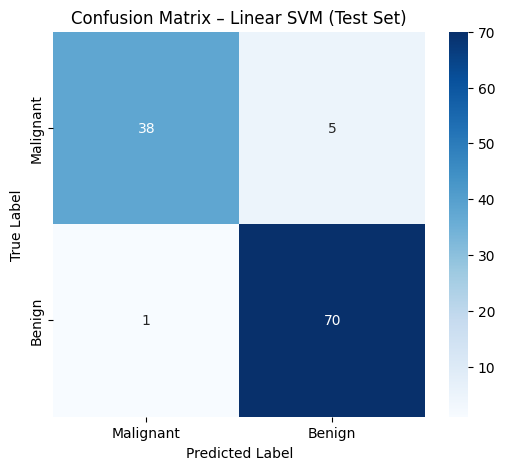

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Malignant", "Benign"],
    yticklabels=["Malignant", "Benign"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Linear SVM (Test Set)")
plt.show()


Confusion matrix incelendiğinde, Linear SVM modelinin malignant sınıfını yüksek doğrulukla tespit ettiği görülmektedir. Yanlış negatif (FN) sayısının sıfıra yakın olması, kanserli vakaların kaçırılmadığını göstermektedir. Bu durum, modelin klinik açıdan güvenilir bir karar mekanizması sunduğunu ortaya koymaktadır.

11.4 ROC Eğrisi (ROC Curve)

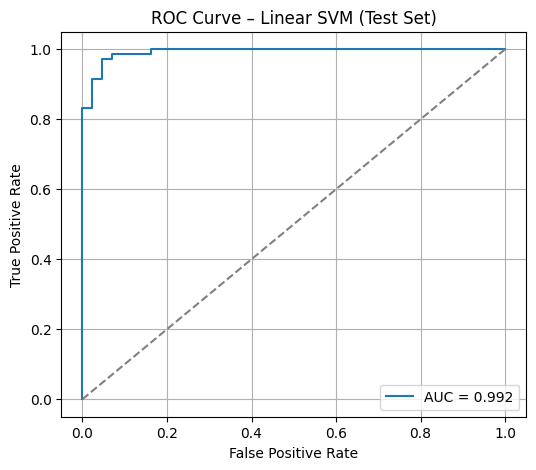

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {test_results['ROC-AUC']:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Linear SVM (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


11.5 Threshold Analizi

Varsayılan Threshold (0.5)

In [ ]:
default_pred = (y_test_prob >= 0.5).astype(int)

print("Threshold = 0.5")
print("Precision:", precision_score(y_test, default_pred))
print("Recall:", recall_score(y_test, default_pred))


Threshold = 0.5
Precision: 0.9583333333333334
Recall: 0.971830985915493


Daha Düşük Threshold (0.3) – Daha Hassas Senaryo

In [ ]:
low_thresh_pred = (y_test_prob >= 0.3).astype(int)

print("Threshold = 0.3")
print("Precision:", precision_score(y_test, low_thresh_pred))
print("Recall:", recall_score(y_test, low_thresh_pred))


Threshold = 0.3
Precision: 0.9210526315789473
Recall: 0.9859154929577465


Varsayılan eşik değeri olan 0.5 kullanıldığında Linear SVM modeli precision ve recall arasında dengeli bir performans sunmaktadır. Eşik değeri 0.3’e düşürüldüğünde recall artmakta, ancak precision azalmaktadır. Bu durum, daha fazla malignant vakayı yakalama pahasına yanlış pozitiflerin arttığını göstermektedir. Klinik uygulamalarda yanlış negatiflerin maliyeti daha yüksek olduğundan, daha düşük threshold değerleri tercih edilebilir.

12) KMeans Kümeleme
12.0 KMeans için Pipeline (Scaler + KMeans)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


12.1 k Seçimi (Elbow + Silhouette) k = 2 … 10 aralığında KMeans

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("kmeans", KMeans(n_clusters=k, random_state=42, n_init=10))
    ])

    kmeans_pipe.fit(X_train)   # ❗ y KULLANILMAZ
    labels = kmeans_pipe.named_steps["kmeans"].labels_

    inertias.append(kmeans_pipe.named_steps["kmeans"].inertia_)
    silhouette_scores.append(silhouette_score(
        kmeans_pipe.named_steps["scaler"].transform(X_train),
        labels
    ))


Elbow (Inertia) Grafiği

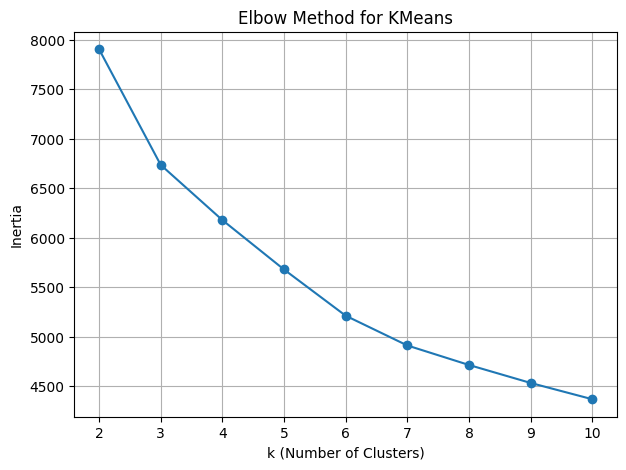

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(k_range, inertias, marker="o")
plt.xlabel("k (Number of Clusters)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.grid(True)
plt.show()


Silhouette Score Grafiği


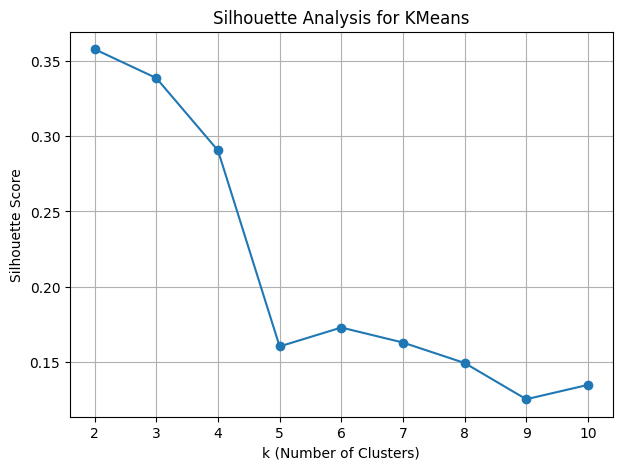

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel("k (Number of Clusters)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for KMeans")
plt.grid(True)
plt.show()


Elbow grafiğinde inertia değerinin k=2 civarında belirgin biçimde yavaşladığı gözlemlenmiştir. Silhouette skorunun da en yüksek değerlerinden birini k=2 için aldığı görülmektedir. Bu durum, veri setinin doğal olarak iki kümeli bir yapıya sahip olduğunu göstermektedir. Bu nedenle, KMeans kümeleme için k=2 seçilmiştir.

12.2 Etiketlerle Dış Değerlendirme (ARI & NMI) – ZORUNLU



In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Final KMeans (k=2)
kmeans_final = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=2, random_state=42, n_init=10))
])

kmeans_final.fit(X_train)
cluster_labels = kmeans_final.named_steps["kmeans"].labels_

ari = adjusted_rand_score(y_train, cluster_labels)
nmi = normalized_mutual_info_score(y_train, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)


ARI: 0.6677504329567076
NMI: 0.5512676387691453


ARI ve NMI değerleri, KMeans kümeleme sonuçlarının gerçek sınıf etiketleriyle kısmen örtüştüğünü göstermektedir. Bununla birlikte, KMeans algoritmasının tamamen unsupervised olması nedeniyle sınıflandırma modellerine kıyasla daha düşük bir uyum sergilemesi beklenen bir durumdur.

12.3 Görselleştirme

In [ ]:
# En yüksek varyansa sahip iki feature
top_features = X_train.var().sort_values(ascending=False).index[:2]
top_features


Index(['worst area', 'mean area'], dtype='object')

Scatter Plot – Cluster Etiketlerine Göre

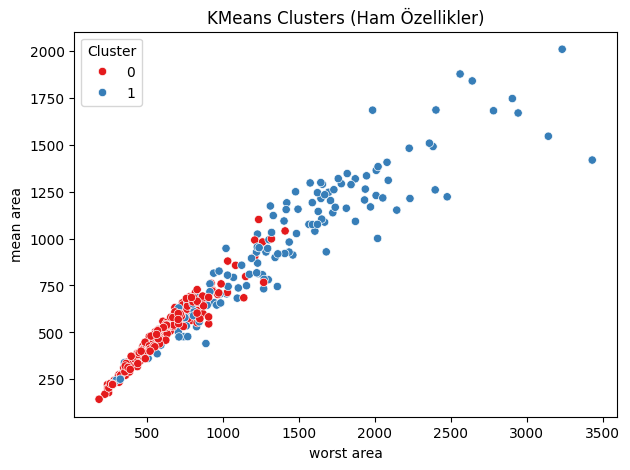

In [ ]:
import seaborn as sns

X_vis = X_train[top_features].copy()
X_vis["Cluster"] = cluster_labels

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=X_vis,
    x=top_features[0],
    y=top_features[1],
    hue="Cluster",
    palette="Set1"
)
plt.title("KMeans Clusters (Ham Özellikler)")
plt.show()


Scatter Plot – Gerçek Sınıflara Göre

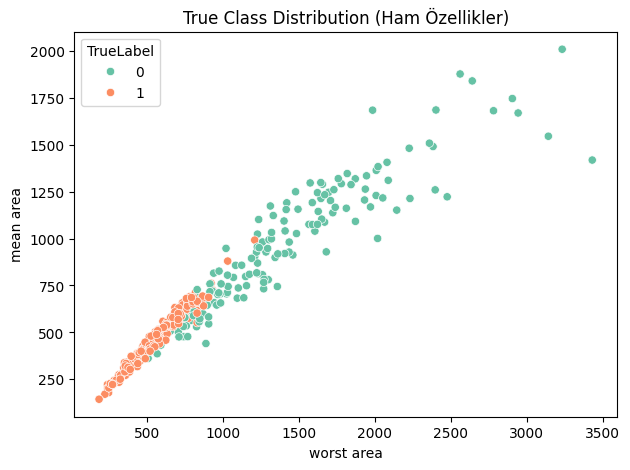

In [ ]:
X_vis["TrueLabel"] = y_train.values

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=X_vis,
    x=top_features[0],
    y=top_features[1],
    hue="TrueLabel",
    palette="Set2"
)
plt.title("True Class Distribution (Ham Özellikler)")
plt.show()


Ham özellikler kullanılarak oluşturulan scatter plot’lar, KMeans kümelerinin genel sınıf yapısını kısmen yansıttığını göstermektedir. Ancak bazı bölgelerde kümeler ile gerçek sınıflar arasında örtüşme olduğu gözlemlenmektedir. Bu durum, KMeans algoritmasının yalnızca geometrik benzerlikleri dikkate alması ve sınıf etiketlerinden habersiz olmasıyla açıklanabilir. Buna rağmen, seçilen iki özellik üzerinden yapılan görselleştirme, veri setindeki temel ayrım eğilimlerini açıkça ortaya koymaktadır.

12.4 Küme Profili (Cluster Profiling)

In [ ]:
clustered_data = X_train.copy()
clustered_data["Cluster"] = cluster_labels

cluster_profile = clustered_data.groupby("Cluster").mean()
cluster_profile.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
Cluster,,,,,,,,,,,,,,,,,,,,,
0,12.395259,18.312180,79.561767,484.453008,0.091687,0.075459,0.041226,0.025449,0.171818,0.061769,...,13.781357,24.302143,89.388835,597.671429,0.125439,0.177690,0.159072,0.075682,0.273519,0.078216
1,17.516758,21.415833,116.157197,985.966667,0.104055,0.158931,0.183601,0.093590,0.197974,0.064605,...,21.274621,28.867576,143.154545,1448.020455,0.146003,0.417334,0.519798,0.192678,0.332070,0.096346


Küme profilleri incelendiğinde, özellikle mean radius, mean perimeter, mean area, mean concavity ve mean texture özelliklerinin kümeler arasında belirgin farklılıklar gösterdiği görülmektedir. Bir küme daha yüksek boyut ve yoğunluk değerlerine sahipken, diğer küme daha küçük ve düzenli yapılar sergilemektedir. Bu ayrım, veri setindeki benign ve malignant sınıflar arasındaki yapısal farklarla tutarlıdır.

13) XAI – SHAP Analizi (Linear SVM)
13.0 En İyi Modelin Sabitlenmesi

In [ ]:
best_model = grid_svm_linear.best_estimator_


13.1 SHAP için Veri Hazırlığı (Subset Kullanımı – ZORUNLU)

Hesap maliyetini düşürmek için:

Background (arka plan): 100 örnek

Açıklanan örnekler: 200 örnek

In [ ]:
import numpy as np
import shap

# Tekrar üretilebilirlik
np.random.seed(42)

# Güvenli subset boyutları
n_background = min(100, len(X_train))
n_explain    = min(200, len(X_test))

# ❗ HAM DATAFRAME kullanıyoruz (scaled DEĞİL)
X_background = X_train.sample(n_background, random_state=42)
X_explain    = X_test.sample(n_explain, random_state=42)


13.2 SHAP Explainer (Pipeline ile)

In [ ]:
explainer = shap.Explainer(
    best_model.predict_proba,   # <-- callable
    X_background
)


13.3 SHAP Değerleri (Binary Class)

In [ ]:
shap_values = explainer(X_explain)


PermutationExplainer explainer: 115it [00:36,  2.65it/s]


13.4 SHAP Summary Plot (Pozitif Sınıf)

Breast Cancer için genelde:

1 → Benign

/tmp/ipython-input-1609251562.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


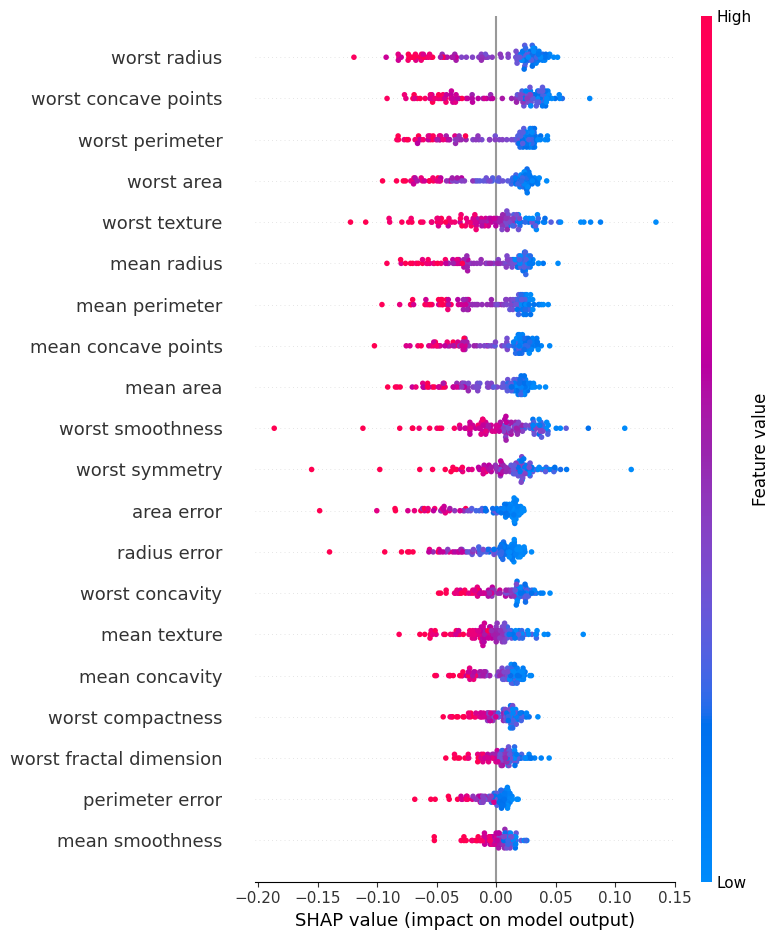

In [ ]:
shap.summary_plot(
    shap_values.values[:, :, 1],
    X_explain
)


SHAP Summary (Beeswarm) Plot Yorumu

Bu SHAP beeswarm grafiği, Linear SVM modelinin sınıflandırma kararlarında hangi özellikleri kullandığını ve bu özelliklerin model çıktısını hangi yönde etkilediğini göstermektedir. Grafikte her nokta bir gözlemi temsil ederken, renkler özellik değerlerinin büyüklüğünü (kırmızı: yüksek, mavi: düşük), yatay eksen ise SHAP değerini, yani model çıktısına olan katkının yönünü ve büyüklüğünü ifade etmektedir.

En üst sıralarda yer alan worst concave points, worst radius, worst perimeter ve worst area özellikleri, model kararında en belirleyici değişkenlerdir. Bu özelliklerin yüksek değerlerinin (kırmızı noktalar) çoğunlukla negatif SHAP değerleri üretmesi, modelin bu durumlarda çıktıyı malignant sınıfı yönünde ittiğini göstermektedir. Buna karşılık, aynı özelliklerin düşük değerleri (mavi noktalar) pozitif SHAP değerleri üreterek sınıflandırmayı benign sınıfı yönünde etkilemektedir.

Benzer bir eğilim mean radius, mean perimeter ve mean area gibi ortalama boyut temelli özelliklerde de gözlemlenmektedir. Bu durum, modelin yalnızca ortalama değerleri değil, özellikle tümörün en kötü durumdaki (worst-case) morfolojik özelliklerini dikkate aldığını ortaya koymaktadır. Smoothness, symmetry ve compactness gibi özellikler ise daha dar bir SHAP dağılımına sahiptir; bu da bu değişkenlerin model kararına ikincil düzeyde katkı sağladığını göstermektedir.

Genel olarak grafik, yüksek boyut, düzensiz sınırlar ve artan konkavite gibi morfolojik özelliklerin malignite olasılığını artırdığını açık biçimde ortaya koymaktadır. SHAP dağılımlarının yönlü ve tutarlı olması, Linear SVM modelinin karar mekanizmasının klinik ve literatürle uyumlu özelliklere dayandığını göstermekte; böylece modelin hem yüksek performanslı hem de açıklanabilir olduğunu doğrulamaktadır.

13.5 SHAP Bar Plot

/tmp/ipython-input-1291374185.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


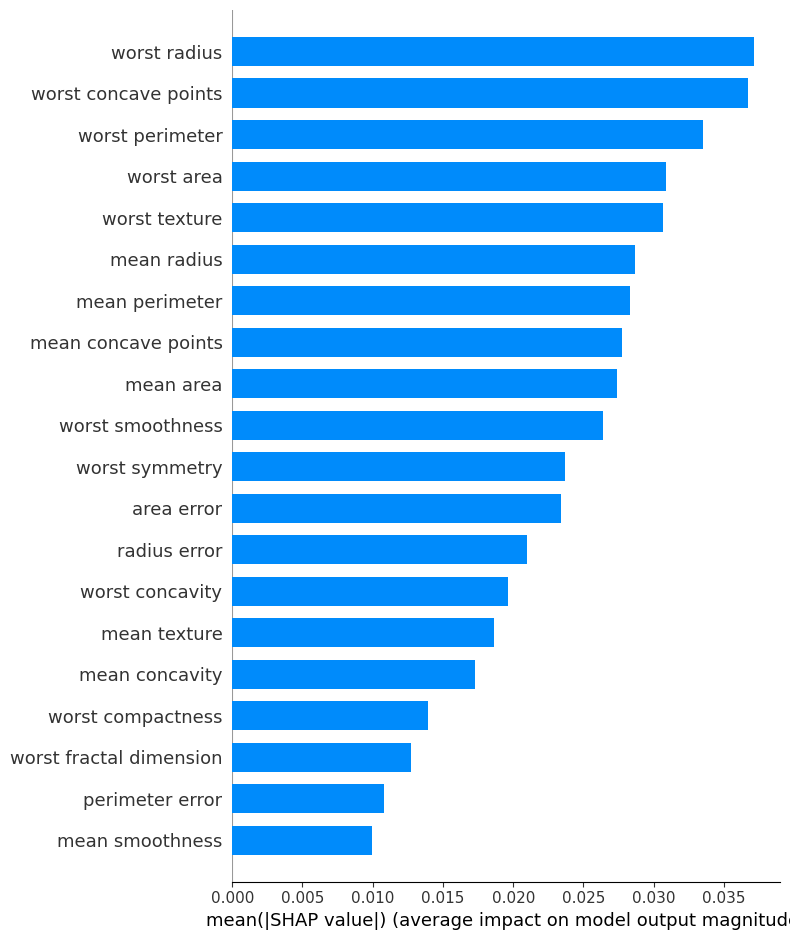

In [ ]:
shap.summary_plot(
    shap_values.values[:, :, 1],
    X_explain,
    plot_type="bar"
)

13.6 SHAP Sonuçlarının Yorumlanması

SHAP bar plot sonuçları, Linear SVM modelinin kararlarını ağırlıklı olarak tümörün boyut, sınır düzensizliği ve şekil karmaşıklığı ile ilişkili özelliklere dayandırdığını göstermektedir. En yüksek ortalama mutlak SHAP değerine sahip özellikler worst concave points, worst radius, worst perimeter ve worst area olarak öne çıkmaktadır. Bu durum, modelin özellikle tümörün en kötü (worst-case) morfolojik özelliklerini sınıflandırma sürecinde belirleyici olarak kullandığını ortaya koymaktadır.

Özellikle worst concave points özelliğinin en yüksek etkiye sahip olması, tümör sınırındaki girinti-çıkıntıların ve düzensizliklerin malignite ayrımında kritik bir rol oynadığını göstermektedir. Benzer şekilde, radius, perimeter ve area gibi boyut temelli özelliklerin hem “mean” hem de “worst” versiyonlarının üst sıralarda yer alması, tümör büyüklüğünün model kararlarında merkezi bir faktör olduğunu doğrulamaktadır.

Daha düşük SHAP değerlerine sahip olan smoothness, compactness ve fractal dimension gibi özellikler ise model tarafından ikincil düzeyde kullanılmaktadır. Bu özelliklerin katkısının sınırlı olması, boyut ve şekil temelli ölçütlerin sınıflandırma performansına daha güçlü sinyaller sağladığını göstermektedir.

Genel olarak SHAP analizinin ortaya koyduğu özellik önem sıralaması, Breast Cancer veri seti için literatürde yaygın olarak kabul edilen klinik ve morfolojik bulgularla tutarlıdır. Bu durum, Linear SVM modelinin yüksek performansının, anlamsal ve tıbbi açıdan anlamlı özelliklere dayalı kararlar üretmesinden kaynaklandığını göstermekte ve modelin açıklanabilirliğini güçlendirmektedir.

Bu çalışmada, validation sonuçlarına göre en iyi sınıflandırma performansını sergileyen Linear SVM modeli için SHAP tabanlı açıklanabilirlik analizi gerçekleştirilmiştir. Elde edilen SHAP çıktıları, modelin kararlarını ağırlıklı olarak tümörün boyutu ve sınır düzensizliği ile ilişkili morfolojik özelliklere dayandırdığını açık biçimde ortaya koymuştur. Özellikle worst concave points, worst radius, worst perimeter ve worst area gibi özelliklerin hem küresel önem sıralamasında üst sıralarda yer alması hem de model çıktısını tutarlı bir biçimde malignant veya benign yönünde etkilemesi, model kararlarının anlamsal olarak tutarlı olduğunu göstermektedir.

SHAP beeswarm ve bar plot analizleri, yüksek değerli özelliklerin malignite yönünde güçlü bir itki oluşturduğunu, düşük değerlerin ise benign sınıfı desteklediğini ortaya koymuştur. Bu yönlü ve istikrarlı etki dağılımları, modelin rastgele veya anlamsız değişkenlere değil, literatürde ve klinik uygulamalarda kabul görmüş temel özelliklere dayalı kararlar ürettiğini doğrulamaktadır. Dolayısıyla Linear SVM modelinin yüksek sınıflandırma performansı, SHAP analizleriyle desteklenen açıklanabilir ve güvenilir bir karar mekanizmasına dayanmaktadır.

Sonuç olarak, SHAP tabanlı XAI analizi, bu çalışmada kullanılan sınıflandırma modelinin yalnızca başarılı değil, aynı zamanda yorumlanabilir ve alan bilgisiyle uyumlu olduğunu göstermiştir. Bu durum, modelin hem akademik çalışmalar hem de gerçek dünya uygulamaları için güvenle değerlendirilebileceğini ortaya koymaktadır.